# Dota 2: Win Probability Prediction

Predict Dota 2 match winner by the first 5 minutes of the game.

Dota 2 is a computer game in the MOBA (Multiplayer Online Battle Arena) genre. It is played by two teams, called Radiant and Dire which consist of five players each. The main goal of the game is to destroy other team's “Ancient", located at the opposite corners of the map. Matches are generated from a queue, taking into account the level of the game all players, known as MMR (Match Making Rank).

Each of the players choose one hero to play with from a pool of 112 heroes in the drafting stage of the game (sometimes called 'picks').

Each hero has a set of features that define his role in the team and playstyle. Among these features there are his basic attribute (Strength, Agility or Intelligence) and unique set of 4 (or for some heroes even more) skills. These features allow each hero to fill several roles in the team, such as “damage dealer" (hero, whose role is to attack the enemies in the fight), “healer" (hero, who mostly heals and otherwise helps his teammates), “caster" (hero, who mostly relies on his spells) etc. Besides attributes each hero can buy items to increase their characteristics or give additional abilities. A set of items purchased by player can significantly affect the success of his individual gameplay and the result of a match.

Dota 2 Match

The training set consists of matches, for which all of the ingame events (like kills, item purchase etc.) as well as match outcome are know. We are given only the first 5 minutes of each match and we need to predict the likelihood of Radiant victory.

The data for this contest is based on the archive of public games by OpenDota.com (formerly YASP). (description by https://www.kaggle.com/c/dota-2-win-probability-prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the train dataset

data_train = pd.read_csv('dota-data/features.csv', index_col='match_id')
print(data_train.shape)
data_train.head()

(97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
# Reading the test dataset

data_test = pd.read_csv('dota-data/features_test.csv', index_col='match_id')
print(data_test.shape)
data_test.head()

(17177, 102)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [4]:
# The test dataset has 102 features, train - 108.
# So, let's drop features, assosiated with the outcome of the match.
drop_list = list(set(data_train.columns) - set(data_test.columns))

y_train = data_train['radiant_win']
X_train = data_train.drop(drop_list, axis=1)

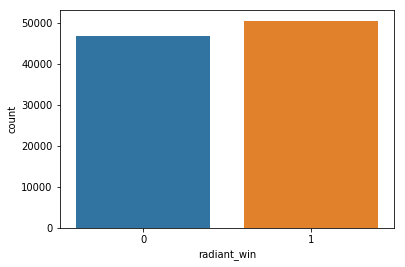

In [5]:
# Classes are balansed

sns.countplot(y_train)

In [6]:
X_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Data columns (total 102 columns):
start_time                     97230 non-null int64
lobby_type                     97230 non-null int64
r1_hero                        97230 non-null int64
r1_level                       97230 non-null int64
r1_xp                          97230 non-null int64
r1_gold                        97230 non-null int64
r1_lh                          97230 non-null int64
r1_kills                       97230 non-null int64
r1_deaths                      97230 non-null int64
r1_items                       97230 non-null int64
r2_hero                        97230 non-null int64
r2_level                       97230 non-null int64
r2_xp                          97230 non-null int64
r2_gold                        97230 non-null int64
r2_lh                          97230 non-null int64
r2_kills                       97230 non-null int64
r2_deaths                      97230 non-null int64
r2_it

In [7]:
data_test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17177 entries, 6 to 114398
Data columns (total 102 columns):
start_time                     17177 non-null int64
lobby_type                     17177 non-null int64
r1_hero                        17177 non-null int64
r1_level                       17177 non-null int64
r1_xp                          17177 non-null int64
r1_gold                        17177 non-null int64
r1_lh                          17177 non-null int64
r1_kills                       17177 non-null int64
r1_deaths                      17177 non-null int64
r1_items                       17177 non-null int64
r2_hero                        17177 non-null int64
r2_level                       17177 non-null int64
r2_xp                          17177 non-null int64
r2_gold                        17177 non-null int64
r2_lh                          17177 non-null int64
r2_kills                       17177 non-null int64
r2_deaths                      17177 non-null int64
r2_it

In [9]:
X_train.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,...,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,...,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,...,0.725331,39.508650,62.442018,15.261950,34.137158,1.907288,1.155609,0.813459,0.710122,40.701397
min,1.430199e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-236.000000,-45.000000,-90.000000,180.000000,0.000000,0.000000,0.000000,0.000000,-84.000000
25%,1.440815e+09,1.000000,22.000000,3.000000,767.000000,746.000000,2.000000,0.000000,0.000000,7.000000,...,0.000000,-31.000000,83.000000,-86.000000,185.000000,2.000000,3.000000,2.000000,0.000000,-31.000000
50%,1.446338e+09,1.000000,50.000000,3.000000,1175.000000,1113.000000,11.000000,0.000000,0.000000,8.000000,...,1.000000,-15.000000,131.000000,-84.000000,203.000000,3.000000,3.000000,2.000000,1.000000,-16.000000
75%,1.448829e+09,7.000000,75.000000,4.000000,1704.000000,1479.000000,19.000000,1.000000,1.000000,10.000000,...,1.000000,9.000000,165.000000,-79.000000,238.000000,4.000000,4.000000,3.000000,1.000000,8.000000
max,1.450313e+09,7.000000,112.000000,6.000000,3319.000000,4332.000000,47.000000,8.000000,5.000000,34.000000,...,25.000000,300.000000,300.000000,296.000000,300.000000,21.000000,9.000000,9.000000,13.000000,300.000000


In [10]:
# Take a look at gaps:

X_train.count(axis=0).where(X_train.count(axis=0) != X_train.shape[0]).dropna(axis=0, how='all', inplace=False)

first_blood_time               77677.0
first_blood_team               77677.0
first_blood_player1            77677.0
first_blood_player2            53243.0
radiant_bottle_time            81539.0
radiant_courier_time           96538.0
radiant_flying_courier_time    69751.0
radiant_first_ward_time        95394.0
dire_bottle_time               81087.0
dire_courier_time              96554.0
dire_flying_courier_time       71132.0
dire_first_ward_time           95404.0
dtype: float64

In [11]:
data_test.count(axis=0).where(data_test.count(axis=0) != data_test.shape[0]).dropna(axis=0, how='all', inplace=False)

first_blood_time               13625.0
first_blood_team               13625.0
first_blood_player1            13625.0
first_blood_player2             9411.0
radiant_bottle_time            14282.0
radiant_courier_time           17050.0
radiant_flying_courier_time    12292.0
radiant_first_ward_time        16847.0
dire_bottle_time               14335.0
dire_courier_time              17047.0
dire_flying_courier_time       12653.0
dire_first_ward_time           16914.0
dtype: float64

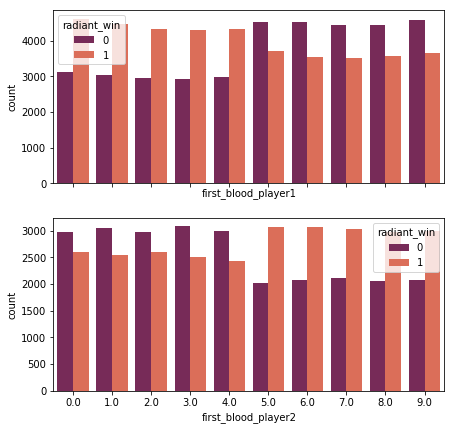

In [12]:
# The columns with gaps in train dataset are the same as in test dataset.
# Also columns with gaps are time and first_blood action.
# Let's take a look at dependance between first_blood action and radiant win.

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True)


sns.countplot(x=X_train['first_blood_player1'], hue=y_train, palette='rocket', ax=ax1)
sns.countplot(x=X_train['first_blood_player2'], hue=y_train, palette='rocket', ax=ax2)

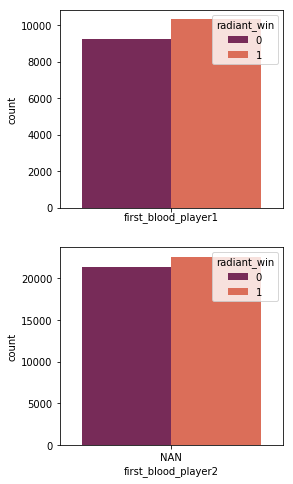

In [13]:
# Let's take a look at dependance between missing values in columns 'first_blood_player1(2)' and radiant win.
# Look's like there is not. So, let's fill gaps with zeros, for start.

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8), sharex=True)

fbpl1 = X_train['first_blood_player1'].fillna('NAN')
fbpl2 = X_train['first_blood_player2'].fillna('NAN')
sns.countplot(x=fbpl1[fbpl1=='NAN'], hue=y_train, palette='rocket', ax=ax1)
sns.countplot(x=fbpl2[fbpl2=='NAN'], hue=y_train, palette='rocket', ax=ax2)

In [14]:
X_train_zeros = X_train.fillna(0, axis = 0)
X_test_zeros = data_test.fillna(0, axis = 0)

## Method 1. Gradient boosting

In [15]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import time
import datetime

/home/daria/playground/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
params = {'n_estimators': np.arange(10, 110, 10),
         'max_depth': [1, 2, 3]}

In [17]:
clf = GradientBoostingClassifier(random_state = 42)
grid = GridSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, cv=KFold(n_splits=3, shuffle = True),
                   return_train_score=True, verbose=True)

In [18]:
grid.fit(X_train_zeros, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 53.5min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [19]:
md_1 = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_max_depth']==1]\
[['param_n_estimators', 'mean_fit_time', 'mean_test_score']]
md_2 = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_max_depth']==2]\
[['param_n_estimators', 'mean_fit_time', 'mean_test_score']]
md_3 = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_max_depth']==3]\
[['param_n_estimators', 'mean_fit_time', 'mean_test_score']]

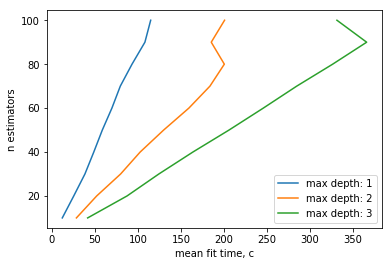

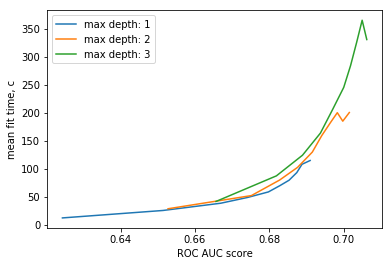

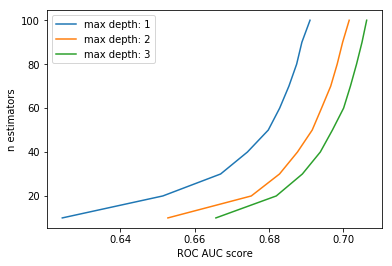

In [21]:
plt.plot(md_1['mean_fit_time'], md_1['param_n_estimators'], label='max depth: 1')
plt.plot(md_2['mean_fit_time'], md_2['param_n_estimators'], label='max depth: 2')
plt.plot(md_3['mean_fit_time'], md_3['param_n_estimators'], label='max depth: 3')
plt.xlabel('mean fit time, c')
plt.ylabel('n estimators')
plt.legend()
plt.show()


plt.plot(md_1['mean_test_score'], md_1['mean_fit_time'], label='max depth: 1')
plt.plot(md_2['mean_test_score'], md_2['mean_fit_time'], label='max depth: 2')
plt.plot(md_3['mean_test_score'], md_3['mean_fit_time'], label='max depth: 3')
plt.xlabel('ROC AUC score')
plt.ylabel('mean fit time, c')
plt.legend()
plt.show()


plt.plot(md_1['mean_test_score'], md_1['param_n_estimators'], label='max depth: 1')
plt.plot(md_2['mean_test_score'], md_2['param_n_estimators'], label='max depth: 2')
plt.plot(md_3['mean_test_score'], md_3['param_n_estimators'], label='max depth: 3')
plt.xlabel('ROC AUC score')
plt.ylabel('n estimators')
plt.legend()
plt.show()

In [22]:
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 3, 'n_estimators': 100}
0.7062347752047818


## Method 2. Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [26]:
# Logistic Regression without tunning:

clf_log = LogisticRegression(random_state = 42)
print('ROC AUC score: ', np.mean(cross_val_score(clf_log, X_train_zeros,
                                                 y_train, scoring='roc_auc',
                                                 cv=KFold(n_splits=3, shuffle = True),
                                                 n_jobs=-1, verbose=True)))

ROC AUC score:  0.513450583952915


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


### Parameter tunning

In [27]:
scaler = StandardScaler()

kf = KFold(n_splits=3, shuffle = True, random_state = 42)

param = {'C': np.power(10.0, np.arange(-6, 6))}

gs = GridSearchCV(clf_log, param, scoring = 'roc_auc', cv = kf, return_train_score=True,
                 verbose=True, n_jobs=-1)

pipeline = Pipeline([('scaler', scaler), ('clf', gs)])

In [28]:
pipeline.fit(X_train_zeros, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.5min finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling..._dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True))])

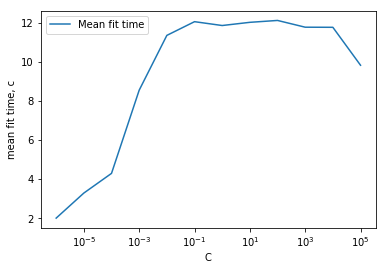

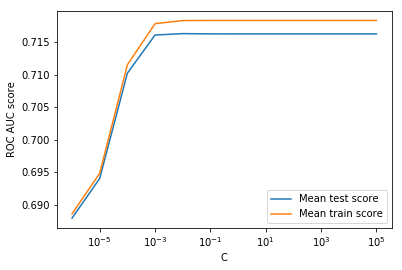

In [29]:
log = pd.DataFrame(pipeline.named_steps['clf'].cv_results_)[['param_C',
                                                             'mean_fit_time',
                                                             'mean_test_score',
                                                            'mean_train_score']]

plt.semilogx(log['param_C'], log['mean_fit_time'], label='Mean fit time')
plt.ylabel('mean fit time, c')
plt.xlabel('C')
plt.legend()
plt.show()

plt.semilogx(log['param_C'], log['mean_test_score'], label='Mean test score')
plt.semilogx(log['param_C'], log['mean_train_score'], label='Mean train score')
plt.ylabel('ROC AUC score')
plt.xlabel('C')
plt.legend()
plt.show()

In [30]:
best_c = pipeline.named_steps['clf'].best_params_
best_score = pipeline.named_steps['clf'].best_score_
print(best_c)
print('ROC AUC score: ',best_score)

{'C': 0.01}
ROC AUC score:  0.7162931013949404


Logistic Regression algorithm seems to be much faster and has a better score.

Let's try to improve it with feature engineering:

First of all, try to drop all categorical features, like:

* lobby_type
* r1..r5_hero
* d1..d5_hero

In [92]:
X_train_zeros_no_cat = X_train_zeros.drop(['lobby_type',
                                           'r1_hero',
                                           'r2_hero',
                                           'r3_hero',
                                           'r4_hero',
                                           'r5_hero',
                                           'd1_hero',
                                           'd2_hero',
                                           'd3_hero',
                                           'd4_hero',
                                           'd5_hero'], axis = 1)

X_test_zeros_no_cat = X_test_zeros.drop(['lobby_type',
                                           'r1_hero',
                                           'r2_hero',
                                           'r3_hero',
                                           'r4_hero',
                                           'r5_hero',
                                           'd1_hero',
                                           'd2_hero',
                                           'd3_hero',
                                           'd4_hero',
                                           'd5_hero'], axis = 1)

In [36]:
grid_2 = GridSearchCV(clf_log, param, scoring = 'roc_auc', cv = kf, return_train_score=True,
                 verbose=True, n_jobs=-1)

pipeline_2 = Pipeline([('scaler', scaler), ('clf', grid_2)])

In [43]:
pipeline_2.fit(X_train_zeros_no_cat, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling..._dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True))])

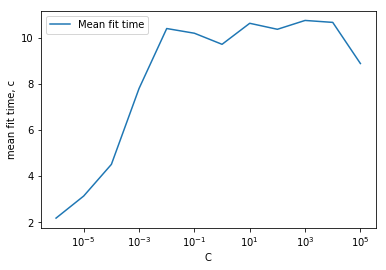

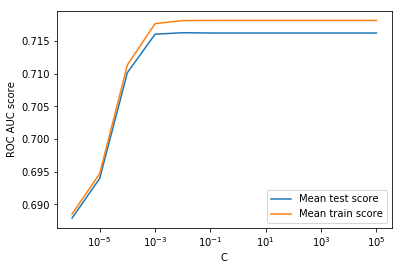

In [44]:
log_2 = pd.DataFrame(pipeline_2.named_steps['clf'].cv_results_)[['param_C',
                                                             'mean_fit_time',
                                                             'mean_test_score',
                                                            'mean_train_score']]

plt.semilogx(log_2['param_C'], log_2['mean_fit_time'], label='Mean fit time')
plt.ylabel('mean fit time, c')
plt.xlabel('C')
plt.legend()
plt.show()

plt.semilogx(log_2['param_C'], log_2['mean_test_score'], label='Mean test score')
plt.semilogx(log_2['param_C'], log_2['mean_train_score'], label='Mean train score')
plt.ylabel('ROC AUC score')
plt.xlabel('C')
plt.legend()
plt.show()

In [46]:
best_c_2 = pipeline_2.named_steps['clf'].best_params_
best_score_2 = pipeline_2.named_steps['clf'].best_score_
print(best_c_2)
print('ROC AUC score_2: ',best_score_2)
print('ROC AUC score: ',best_score)

{'C': 0.01}
ROC AUC score_2:  0.7162734794342115
ROC AUC score:  0.7162931013949404


Second score has bin down. Probably, it's because we deleted important features about herous.
Let's try decoding the features with "bag of words".

From describtion, we're knew that there is 112 unique herous:

In [52]:
hero_cols = [col for col in X_train_zeros.columns if col.endswith('hero')]

X_train_zeros[hero_cols].describe()

,r1_hero,r2_hero,r3_hero,r4_hero,r5_hero,d1_hero,d2_hero,d3_hero,d4_hero,d5_hero
count,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,51.517104,52.183452,52.710491,52.648092,52.625630,51.990106,52.708547,52.755137,52.922421,53.059694
std,32.564211,32.674077,32.560923,32.670519,32.608231,32.442153,32.500960,32.421325,32.460902,32.535112
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,22.000000,25.000000,25.000000,25.000000,25.000000,23.000000,25.000000,25.000000,25.000000,25.000000
50%,50.000000,50.000000,51.000000,51.000000,51.000000,50.000000,51.000000,51.000000,51.000000,51.000000
75%,75.000000,75.000000,76.000000,78.000000,76.000000,75.000000,76.000000,75.000000,76.000000,78.000000
max,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000


In [56]:
X_train_zeros['r1_hero'].max()

112

#### *Bag of words*

There are N (unique) heros in the game. So, let it be N features:
* i-th feature is equal to $0$, if hero didn't play in the match
* i-th feature is equal to $1$, if hero participated in the math and played for the Radiant team
* i-th feature is equal to $-1$, if hero participated in the math and played for the Dire team

In [70]:
# N - count unique heros
N = 112
X_pick = np.zeros((X_train_zeros.shape[0], N))

for i, match_id in enumerate(X_train_zeros.index):
    for p in range(1,6):
        X_pick[i, X_train_zeros.loc[match_id, 'r%d_hero' % p]-1] = 1
        X_pick[i, X_train_zeros.loc[match_id, 'd%d_hero' % p]-1] = -1

In [80]:
cat_features = pd.DataFrame.from_dict({match_id : X_pick[i] 
                        for i, match_id in enumerate(X_train_zeros.index)},
                       orient='index')

In [83]:
X_train_zeros_encoded = pd.concat([X_train_zeros_no_cat, cat_features], axis=1, sort=False)
X_train_zeros_encoded.shape

(97230, 203)

In [85]:
grid_3 = GridSearchCV(clf_log, param, scoring = 'roc_auc', cv = kf, return_train_score=True,
                 verbose=True, n_jobs=-1)

pipeline_3 = Pipeline([('scaler', scaler), ('clf', grid_3)])

In [86]:
pipeline_3.fit(X_train_zeros_encoded, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.6min finished


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling..._dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True))])

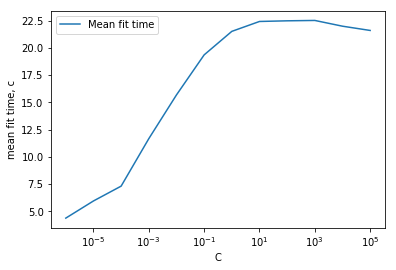

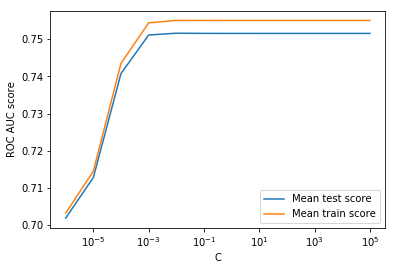

In [87]:
log_3 = pd.DataFrame(pipeline_3.named_steps['clf'].cv_results_)[['param_C',
                                                             'mean_fit_time',
                                                             'mean_test_score',
                                                            'mean_train_score']]

plt.semilogx(log_3['param_C'], log_3['mean_fit_time'], label='Mean fit time')
plt.ylabel('mean fit time, c')
plt.xlabel('C')
plt.legend()
plt.show()

plt.semilogx(log_3['param_C'], log_3['mean_test_score'], label='Mean test score')
plt.semilogx(log_3['param_C'], log_3['mean_train_score'], label='Mean train score')
plt.ylabel('ROC AUC score')
plt.xlabel('C')
plt.legend()
plt.show()

In [91]:
best_c_3 = pipeline_3.named_steps['clf'].best_params_
best_score_3 = pipeline_3.named_steps['clf'].best_score_
print('ROC AUC score_3: ', best_score_3)
print('ROC AUC score_2: ',best_score_2)
print('ROC AUC score: ',best_score)

ROC AUC score_3:  0.7515972929637329
ROC AUC score_2:  0.7162734794342115
ROC AUC score:  0.7162931013949404


Here we see, that "hero"-features encoding rised ROC AUC score.

Let's encode features in test dataset and make predictions for matches:

In [94]:
X_pick_test = np.zeros((X_test_zeros.shape[0], N))

for i, match_id in enumerate(X_test_zeros.index):
    for p in range(1,6):
        X_pick_test[i, X_test_zeros.loc[match_id, 'r%d_hero' % p]-1] = 1
        X_pick_test[i, X_test_zeros.loc[match_id, 'd%d_hero' % p]-1] = -1
        
cat_features_test = pd.DataFrame.from_dict({match_id : X_pick_test[i] 
                        for i, match_id in enumerate(X_test_zeros.index)},
                       orient='index')

X_test_zeros_encoded = pd.concat([X_test_zeros_no_cat, cat_features_test], axis=1, sort=False)

In [95]:
y_proba_test = pipeline_3.predict_proba(X_test_zeros_encoded)[:, 1]

In [97]:
print(min(y_proba_test))
print(max(y_proba_test))

0.008490951947241126
0.9962776240356744
